In [221]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [222]:
%sql postgresql://student@/project4

'Connected: student@project4'

In [223]:
#plotly.offline doesn't push your charts to the clouds
import plotly.offline as pyo
#allows us to create the Data and Figure objects
from plotly.graph_objs import *
#plotly.plotly pushes your charts to the cloud  
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
#pandas is a data analysis library
import pandas as pd
from pandas import DataFrame

In [224]:
import pandas.io.sql as pdsql

In [225]:
import psycopg2

In [226]:
conn = psycopg2.connect("dbname='project4' user='student' host='localhost' password=''")

In [227]:
%%sql
SELECT  Service_type.sr_description, COUNT(*) AS count 
FROM facts 
JOIN Service_type ON facts.Service_type_key = Service_type.Service_type_key 
GROUP BY 1 
ORDER BY count DESC 
LIMIT 10;

10 rows affected.


sr_description,count
Austin Code - Request Code Officer,75968
ARR Dead Animal Collection,19227
ARR Missed Recycling,19082
Loose Dog,17915
Animal Control - Assistance Request,16163
Street Light Issue- Address,13865
ARR Missed Yard Trimmings /Organics,12749
Graffiti Abatement,11883
Water Waste Report,11847
Injured / Sick Animal,10888


In [228]:
%matplotlib inline

<Container object of 10 artists>

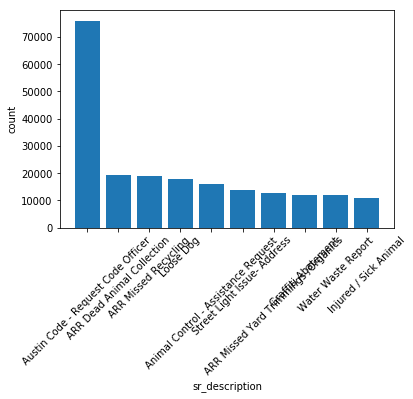

In [229]:
_.bar()

In [230]:
temp = pdsql.read_sql('''SELECT Service_type.sr_type_code, Service_type.sr_description, COUNT(*) AS count 
FROM facts
JOIN Service_type ON facts.Service_type_key = Service_type.Service_type_key 
GROUP BY 1,2 
ORDER BY count DESC 
LIMIT 10;
               ''',conn)

In [231]:
%%sql 
Select Distinct year
From hour;

5 rows affected.


year
2014
2017
2013
2015
2016


In [232]:
number= {'type' : 'bar',
                     'x' : temp.sr_description,
                     'y' : temp["count"],
                     'marker' : {'color' : 'lightblue',
                                'line' : {'color' : '#333',
                                          'width' : 2}},
                     'opacity' : 0.5,}
                     

layout = {'title' : "Service Types in Total (From 2014-2017)",
         'xaxis' : {'title' : 'Service Types'},
         'yaxis' : {'title' : 'Number of cases'},
         }
fig = {'data' : [number],
      'layout' : layout}
pyo.iplot(fig)

In [233]:
temp = pdsql.read_sql('''
SELECT hour.month_of_year_str, COUNT(*) AS count
FROM facts
JOIN hour ON facts.created_date_key = hour.hour_key
GROUP BY 1,hour.month_of_year
Order By hour.month_of_year;''',conn)

In [234]:
number= {'type' : 'bar',
                     'x' : temp.month_of_year_str,
                     'y' : temp["count"],
                     'marker' : {'color' : 'pink',
                                'line' : {'color' : '#333',
                                          'width' : 2}},
                     'opacity' : 0.5,}
                     

layout = {'title' : "Number of Case among different months ",
         'xaxis' : {'title' : 'Month'},
         'yaxis' : {'title' : 'Number of cases'},
         }
fig = {'data' : [number],
      'layout' : layout}
pyo.iplot(fig)

In [235]:
%%sql
DROP TABLE IF EXISTS temp;
SELECT hour.month_of_year,hour.month_of_year_str AS month, Service_type.sr_description, COUNT(*) AS count
INTO temp
FROM facts
JOIN hour ON facts.created_date_key = hour.hour_key
JOIN Service_type ON facts.Service_type_key = Service_type.Service_type_key
GROUP BY hour.month_of_year,hour.month_of_year_str,Service_type.sr_description

Done.
1382 rows affected.


[]

In [236]:
%%sql
SELECT month_of_year,month,sr_description,count , RANK() OVER (PARTITION BY month ORDER BY count DESC) AS rk
INTO temp2
FROM temp
;

1382 rows affected.


[]

In [237]:
%%sql
SELECT month,sr_description,count ,rk
from temp2
where rk<=5
Order by month_of_year,rk;

60 rows affected.


month,sr_description,count,rk
January,Austin Code - Request Code Officer,4105,1
January,ARR Missed Recycling,1662,2
January,Loose Dog,1218,3
January,Graffiti Abatement,1208,4
January,ARR Dead Animal Collection,1125,5
February,Austin Code - Request Code Officer,3805,1
February,Loose Dog,1237,2
February,ARR Missed Recycling,1164,3
February,Loud Music,1031,4
February,ARR Dead Animal Collection,1028,5


In [238]:
%%sql 
DROP TABLE IF EXISTS temp,temp2;

Done.


[]

In [239]:
%%sql
SELECT Service_type.owning_department, COUNT(*) AS count
FROM facts 
JOIN Service_type ON facts.Service_type_key = Service_type.Service_type_key
GROUP BY owning_department
ORDER BY count DESC

17 rows affected.


owning_department,count
Austin Code Department,79084
Animal Services Office,67013
Austin Resource Recovery,61277
Transportation,31007
Public Works,29849
Parks & Recreation Department,15265
Austin Energy Department,14516
Health & Human Services,11890
Economic Development Department,11248
Austin Water Utility,10947


In [240]:
temp = pdsql.read_sql('''
SELECT Service_type.owning_department, COUNT(*) AS count
FROM facts 
JOIN Service_type ON facts.Service_type_key = Service_type.Service_type_key
GROUP BY owning_department
ORDER BY count DESC
limit 10;''',conn)

In [241]:
temp

,owning_department,count
0,Austin Code Department,79084
1,Animal Services Office,67013
2,Austin Resource Recovery,61277
3,Transportation,31007
4,Public Works,29849
5,Parks & Recreation Department,15265
6,Austin Energy Department,14516
7,Health & Human Services,11890
8,Economic Development Department,11248
9,Austin Water Utility,10947


In [242]:
number= {'type' : 'bar',
                     'x' : temp.owning_department,
                     'y' : temp["count"],
                     'marker' : {'color' : 'blue',
                                'line' : {'color' : '#333',
                                          'width' : 2}},
                     'opacity' : 0.5,}
                     

layout = {'title' : "Number of Case of its owning_department top10 ",
         'xaxis' : {'title' : 'deparment types'},
         'yaxis' : {'title' : 'Number of cases'},
         }
fig = {'data' : [number],
      'layout' : layout}
pyo.iplot(fig)

Let's focus on number of case of top5 popular deparments

In [243]:
%%sql
SELECT hour.year, hour.month_of_year,  Service_type.owning_department, COUNT(owning_department) AS count
FROM facts 
JOIN Service_type ON facts.Service_type_key = Service_type.Service_type_key
JOIN hour ON facts.created_date_key = hour.hour_key
Where Service_type.owning_department = 'Austin Code Department'
OR Service_type.owning_department = 'Animal Services Office'
OR Service_type.owning_department ='Austin Resource Recovery'
OR Service_type.owning_department ='Transportation'
OR Service_type.owning_department ='Public Works'
GROUP BY 1,2, owning_department
ORDER BY 1,2, count DESC;

235 rows affected.


year,month_of_year,owning_department,count
2014,1,Austin Resource Recovery,2214
2014,1,Animal Services Office,1589
2014,1,Transportation,570
2014,1,Public Works,376
2014,1,Austin Code Department,1
2014,2,Austin Resource Recovery,1623
2014,2,Animal Services Office,1400
2014,2,Transportation,670
2014,2,Austin Code Department,395
2014,2,Public Works,281


In [276]:
temp = pdsql.read_sql('''
SELECT hour.year, hour.month_of_year,  Service_type.owning_department, COUNT(owning_department) AS count
FROM facts 
JOIN Service_type ON facts.Service_type_key = Service_type.Service_type_key
JOIN hour ON facts.created_date_key = hour.hour_key
Where Service_type.owning_department = 'Austin Code Department'
OR Service_type.owning_department = 'Animal Services Office'
OR Service_type.owning_department ='Austin Resource Recovery'
OR Service_type.owning_department ='Transportation'
OR Service_type.owning_department ='Public Works'
GROUP BY 1,2, owning_department
ORDER BY 1,2, count DESC;''',conn)

In [277]:
temp = temp.rename(columns={"month_of_year":"month"})

In [278]:
temp["time"]=temp.year.apply(lambda x: str(x)+ "-") +temp.month.apply(lambda x: str(x))

In [279]:
temp["time"] = pd.to_datetime(temp["time"])

In [280]:
temp.head()

,year,month,owning_department,count,time
0,2014,1,Austin Resource Recovery,2214,2014-01-01
1,2014,1,Animal Services Office,1589,2014-01-01
2,2014,1,Transportation,570,2014-01-01
3,2014,1,Public Works,376,2014-01-01
4,2014,1,Austin Code Department,1,2014-01-01


In [281]:
temp = temp.drop(["year","month"],axis =1)

In [282]:
temp.head()

,owning_department,count,time
0,Austin Resource Recovery,2214,2014-01-01
1,Animal Services Office,1589,2014-01-01
2,Transportation,570,2014-01-01
3,Public Works,376,2014-01-01
4,Austin Code Department,1,2014-01-01


In [284]:
temp = temp.pivot(index = "time",columns = "owning_department",values = "count")

In [287]:
temp = temp.reset_index()

In [288]:
temp.columns

Index(['time', 'Animal Services Office', 'Austin Code Department',
       'Austin Resource Recovery', 'Public Works', 'Transportation'],
      dtype='object', name='owning_department')

In [291]:
def createStackedPropArea(df, time, cols, hover, title, yaxisTitle): 
    PCcols = []
    traces = []
    
    stackedAreaDF = df.loc[:, ([time] + cols)]
    stackedAreaDF.fillna(0, inplace=True)
        
    stackedAreaDF['Total'] = stackedAreaDF[cols].sum(axis =1)
    
    for col in cols:
        stackedAreaDF["pc_"+str(col)] = stackedAreaDF[col] / stackedAreaDF['Total']
        PCcols.append("pc_"+str(col))
        
    stackedPCAreaDF = stackedAreaDF[PCcols].cumsum(axis=1)
    stackedAreaData = stackedAreaDF[PCcols + [time]].merge(stackedPCAreaDF[PCcols], 
                                        left_index = True,
                                         right_index = True,
                                        suffixes = ('_o','_c'))

    for col in PCcols:       
        stackedAreaData[col + '_t'] = "<b>" + str(col)[3:-6]  + "</b><br>" + str(hover) + stackedAreaData[col + "_o"].apply(lambda x:
            "{:.0%}".format(x))
        
        
        traces.append({'type' : 'scatter',
                      'x' : stackedAreaData[time],
                      'y' : stackedAreaData[col + "_c"],
                       'text' : stackedAreaData[col + "_t"],
                       'hoverinfo' : 'text+x',
                      'name' : col[3:-6],
                      'mode' : 'lines',
                      'fill' : 'tonexty'})
    
    data = Data(traces)
    layout = {'title' : title,
             'xaxis' : {'title' : time},
             'yaxis' : {'title' : yaxisTitle,
                       'tickformat' : '%'},
              'hovermode' : 'closest'}
    fig = Figure(data = data, layout = layout)
    pyo.iplot(fig)

    return stackedAreaData,fig
    
    
C02Prop = createStackedPropArea(temp, 'time', ['Animal Services Office', 'Austin Code Department',
       'Austin Resource Recovery', 'Public Works', 'Transportation'], 'Proportion of number of cases: ',
                            "Proportion of number of cases, 2014-2017", 'Proportion of number of cases')